## Image Classification: efficientNet, mobileNet

In [1]:
import pandas as pd
import tensorflow # as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import datetime
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [2]:
begin_time = datetime.datetime.now()
working_dir = "/home/renyc/31009/final_project/humpback-whale-identification/data/"
img_path = "/home/renyc/31009/final_project/humpback-whale-identification/data/true_train_5005"
batch_size = 100
class_mode = 'categorical'

In [3]:
width = 100
height = 100
target_size = (width,height)

In [4]:
train_df = pd.read_csv(working_dir+"train.csv")
train_df.head(), len(train_df)

(           Image         Id
 0  0000e88ab.jpg  w_f48451c
 1  0001f9222.jpg  w_c3d896a
 2  00029d126.jpg  w_20df2c5
 3  00050a15a.jpg  new_whale
 4  0005c1ef8.jpg  new_whale,
 25361)

In [5]:
train_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(shear_range = 0.5,
                                                                        horizontal_flip = True,
                                                                        preprocessing_function=preprocess_input,
                                                                        validation_split=0.2)
#                                                                        rescale = 1./255)

training_set = train_datagen.flow_from_directory(directory=img_path,
                                                target_size=target_size,
                                                batch_size=batch_size,
                                                class_mode=class_mode,
                                                subset='training')

validation_set = train_datagen.flow_from_directory(directory=img_path,
                                                target_size=target_size,
                                                batch_size=batch_size,
                                                class_mode=class_mode,
                                                subset='validation')

Found 22016 images belonging to 5005 classes.
Found 3345 images belonging to 5005 classes.


In [6]:
num_class = training_set.num_classes

In [7]:
print()
print("~~~~~~~~~~~~~~~~~~~~~~~~~")
midpt = datetime.datetime.now()
print("time for preparing images and import", midpt-begin_time)


~~~~~~~~~~~~~~~~~~~~~~~~~
time for preparing images and import 0:00:12.656575


In [8]:
##"""# Model"""
def build_model_CNN():
    model = Sequential()
    model.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (width, height, 3)))
    model.add(BatchNormalization(axis = 3, name = 'bn0'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), name='max_pool'))
    model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
    model.add(Activation('relu'))
    model.add(AveragePooling2D((3, 3), name='avg_pool'))
    model.add(Flatten())
    model.add(Dense(500, activation="relu", name='rl'))
    model.add(Dropout(0.8))
    model.add(Dense(num_class, activation='softmax', name='sm'))
    return model

In [9]:
def build_model_pretrained(pretrained):
    assert (pretrained=="MobileNetV2" or pretrained=="EfficientNetB0"), 'pretrained not supported'
    if pretrained == "MobileNetV2":
        base_model = tensorflow.keras.applications.mobilenet_v2.MobileNetV2(
            include_top=False, weights='imagenet', input_shape=(width, height, 3))
    if pretrained == "EfficientNetB0":
        base_model = tensorflow.keras.applications.efficientnet.EfficientNetB0(
          include_top=False, weights='imagenet', input_shape=(width, height, 3))
    inputs = Input(shape=(width, height, 3))
    x = base_model(inputs)
    
    for layer in base_model.layers:
        layer.trainable=False

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(1024,activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(1024,activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_class, activation='softmax')(x)
    model = tensorflow.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

Choose your model here

In [20]:
model = build_model_pretrained("EfficientNetB0")

In [21]:
adam = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 4, 4, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1280)              5120      
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049

In [22]:
## """# Training the Model without Grid Search"""
filepath = "/home/renyc/31009/final_project/humpback-whale-identification/code/models-roy/"+'mobilenet-{epoch:02d}-accuracy-{accuracy:.2f}.hdf5'
checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_best_only=True)

In [23]:
history = model.fit(training_set, 
                    epochs=100, batch_size=100, 
#                    callbacks=[checkpoint],
                    validation_data=validation_set,
                    verbose=1)

Epoch 1/100
221/221 [==============================] - 940s 4s/step - loss: 6.3103 - accuracy: 0.3461 - val_loss: 4.1796 - val_accuracy: 0.5809
Epoch 2/100
221/221 [==============================] - 271s 1s/step - loss: 5.5962 - accuracy: 0.3518 - val_loss: 3.2548 - val_accuracy: 0.5830
Epoch 3/100
221/221 [==============================] - 276s 1s/step - loss: 5.2459 - accuracy: 0.3543 - val_loss: 3.0397 - val_accuracy: 0.5877
Epoch 4/100
221/221 [==============================] - 277s 1s/step - loss: 4.8253 - accuracy: 0.3569 - val_loss: 2.8748 - val_accuracy: 0.5898
Epoch 5/100
221/221 [==============================] - 275s 1s/step - loss: 4.4251 - accuracy: 0.3647 - val_loss: 2.7333 - val_accuracy: 0.5955
Epoch 6/100
221/221 [==============================] - 274s 1s/step - loss: 4.0101 - accuracy: 0.3760 - val_loss: 2.6919 - val_accuracy: 0.5910
Epoch 7/100
221/221 [==============================] - 276s 1s/step - loss: 3.6005 - accuracy: 0.3883 - val_loss: 2.7004 - val_accuracy:

In [24]:
hist_df = pd.DataFrame(history.history)
with open('efnb0-history-epoch100-batch100-res100-adam0.001.json',mode='w') as f:
    hist_df.to_json(f)

In [25]:
model.save_weights('./weights/efnb0-epoch100-batch100-res100-adam0.001.h5')
model.save('efnb0-epoch100-batch100-res100-adam0.001.h5')

History plot

In [10]:
my_history_efn = pd.read_json('./history/efnb0-history-epoch100-batch100-res100-adam0.001.json')

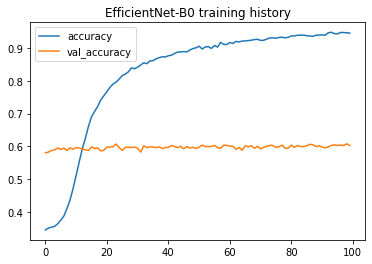

In [13]:
my_history_efn[['accuracy','val_accuracy']].plot(title="EfficientNet-B0 training history")